# Симулятор азартной игры в стиле crash game.

## Правила
 - Игрок делает **ставку** любой суммы на случайный **множитель** от 1.1 до 50.
 - Выпадает случайный **множитель** число от 0 до 50.
 - С вероятностью **zerosratio** игрок не получает вообще ничего. множитель = 0. Пусть zerosratio = 0.13 .
 - Вероятность выпадения выигрыша обратно пропорциональна его множителю. Но, поскольку это множитель, то вероятность нелинейно пропорциональна, а обратно экспонентциально пропорциональна. То есть, распределение множителей соответствует так называемому **экспонентциальному** распределению.
 - Играем всегда фиксированное число ходов. Игра не прекращается если деньги закончились. Если сумма денег отрицательна - это просто долг игрока. Исследовать нужно и эти случаи тоже.

## Цель
 Выработать выигрышную стратегию

## Передположение психологического характера
 Если все игроки склонны ставить  повышенные ставки, то организатор сосредоточен на получении прибыли от них. 
 Тогда игрок обладающий достаточным терпением и суммой, может оказаться в выигрыше.

In [1]:
# набор стандартных библиотек для python
import pandas as pd
import numpy as np
import numba
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import njit, jit
from numpy.random import exponential

In [2]:
zerosratio=0.13

# Boostrap 
В этой версии не используется генератор случайных чисел.
Загружаем собранные данные из файла и формируем  из них последовательности желаемого размера. 

In [15]:
df=pd.read_csv('crash_data.tsv', sep='\\t',header=None, names=['timestamp','point'],parse_dates= [0],dayfirst=True)
df.dtypes

/tmp/ipykernel_931/2750862015.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv('crash_data.tsv', sep='\\t',header=None, names=['timestamp','point'],parse_dates= [0],dayfirst=True)


timestamp    datetime64[ns]
point               float64
dtype: object

In [16]:
df.head(3)

,timestamp,point
0,2023-03-01 01:27:30,9.17
1,2023-03-01 01:27:38,0.00
2,2023-03-01 01:27:59,4.61


In [27]:
def mult_values(zerosratio: float, size: int) -> np.ndarray:
    return df.point.sample(size,replace=True).to_numpy() 

mult_values(0.13,5)

array([1.24, 6.23, 2.08, 4.84, 5.86])

In [28]:
rvalues = mult_values(0.13,1000)
rvalues[:10]

array([0.  , 0.  , 5.12, 2.55, 4.31, 1.56, 7.35, 1.21, 3.48, 9.81])

Проверим правдоподобность **данных** в помощью гистограммы распределений

<AxesSubplot: >

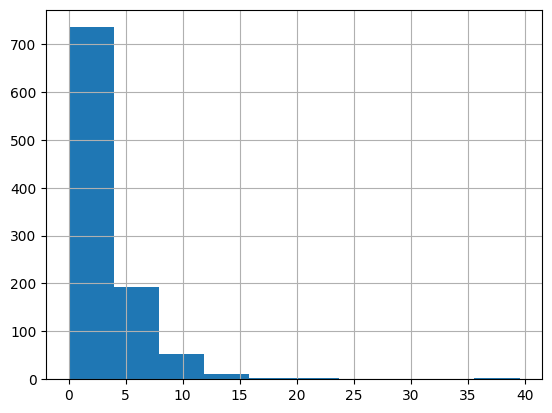

In [29]:
s = pd.Series(rvalues)
s.hist(bins=10)

In [30]:
# Старая функция с аналитическими коээфициентами:
#@jit
def mult_values_analitics(zerosratio: float,size: int) -> np.ndarray :
    zeros_values = np.zeros(round(size*zerosratio))
    exp_values = 1+np.random.exponential(scale=2.0, size=round((1-zerosratio)*size))
    result = np.concatenate((zeros_values, exp_values), axis=None)
    result = np.around(result,2)
    np.random.shuffle(result)
    return result

<AxesSubplot: >

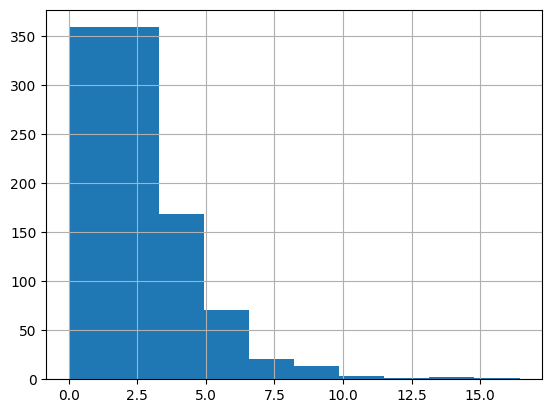

In [31]:
rvalues_analitics = mult_values_analitics(0.13,1000)
s2 = pd.Series(rvalues_analitics)
s2.hist(bins=10)

*Задание со звездочкой  : 
перерисовать гистограмму в логарифмической шкале. Сделать выводы. 
Получится прямая ?*
        

# Проверка различных стратегий

Все стратегии проверяются схожими по структуре функциями:

    - на вход подается массив исходов
    - на выходе массив возможных исходов

## Стратегия: постоянная ставка на некий коэффициент
Просто ставим 100  руб на постоянный коээфициент

In [32]:
@njit
def strategy_const_e (balance: float)  -> float:
    return 1.5

Разовая симуляция для отладки (и вообще-то в numba хотя бы раз вызвать функцию для компиляции)

In [33]:
start_balance = 5000.0
game_rounds = 100 # продолжительность серии игры
rvalues = mult_values(0.13,game_rounds)

@njit
def simulate_one_game(start_balance: float, sequence: np.ndarray) -> float:
    balance = start_balance
    bet = 100 # постоянная сумма ставки 
    bet_rate = strategy_const_e(balance) # постоянная стратегия
    for outcome  in sequence:
        if outcome >= bet_rate and outcome >= 1.1 :
            balance += bet * bet_rate
        else:
            balance -= bet 
    return balance

total = simulate_one_game(start_balance,rvalues)
print(total)

10500.0


Серия симуляций для выяснения **распределения** прогнозируемой суммы. 

In [34]:
game_rounds = 1000 # число подходов в одной игре, раз.
number_of_games = 10000 # число симуляций
game_results = np.zeros(number_of_games)

#@jit
def simulate_all_games ():
    for i in range(number_of_games):
        rvalues = mult_values(0.13,game_rounds)
        b = simulate_one_game(5000,rvalues)
        game_results[i]=simulate_one_game(5000,rvalues)

simulate_all_games()
# Контроль первых 10 результатов 
game_results[1:10]

array([65000., 64500., 69000., 66750., 72250., 69250., 63000., 73250.,
       70000.])

Теперь можно рассуждать об перспективах в игре с учетом **number_of_games** равновозможных вариантов будущего.

Ожидаемая сумма распределиться по этому графику:

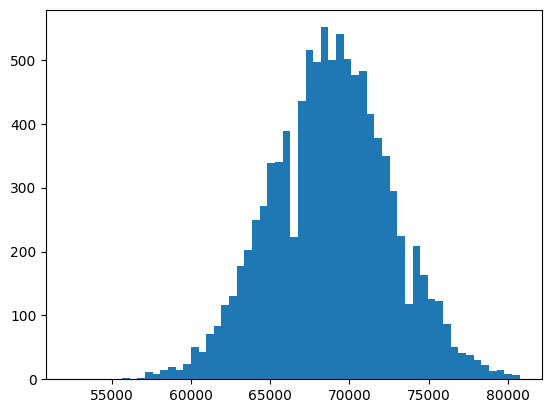

In [35]:
plt.hist(game_results,bins='auto');

In [36]:
print('Начали с ', start_balance, '. В среднем ожидаем выиграть', game_results.mean(), 
      ', но разброс +-',game_results.std())

Начали с  5000.0 . В среднем ожидаем выиграть 68826.15 , но разброс +- 3813.399228706588


# Далее 
Поиск оптимального коээфициента через стохастический градиентный спуск.